In [2]:
%matplotlib inline
import pyNN.nest as sim
from pyNN.utility import get_simulator, normalized_filename

import numpy as np
import matplotlib.pyplot as plt

def get_pop():

    SENSORPARAMS = {'v_rest': -60.5,
                    'cm': 0.025,
                    'tau_m': 10.,
                    'tau_refrac': 10.0,
                    'tau_syn_E': 2.5,
                    'tau_syn_I': 2.5,
                    'e_rev_E': 0.0,
                    'e_rev_I': -75.0,
                    'v_thresh': -60.0,
                    'v_reset': -60.5}

    GO_ON_PARAMS = {'v_rest': -60.5,
                    'cm': 0.025,
                    'tau_m': 10.0,
                    'e_rev_E': 0.0,
                    'e_rev_I': -75.0,
                    'v_reset': -61.6,
                    'v_thresh': -60.51,
                    'tau_refrac': 10.0,
                    'tau_syn_E': 2.5,
                    'tau_syn_I': 2.5}

    population = sim.Population(8, sim.IF_cond_alpha())
    population[0:5].set(**SENSORPARAMS)
    population[5:6].set(**GO_ON_PARAMS)
    population[6:8].set(**SENSORPARAMS)

    syn_params = {'U': 1.0, 'tau_rec': 1.0, 'tau_facil': 1.0}

    # Synaptic weights
    WEIGHT_RED_TO_ACTOR = 1.5e-4
    WEIGHT_RED_TO_GO_ON = 1.2e-3  # or -1.2e-3?
    WEIGHT_GREEN_BLUE_TO_ACTOR = 1.05e-4
    WEIGHT_GO_ON_TO_RIGHT_ACTOR = 1.4e-4
    DELAY = 1

    # Connect neurons
    CIRCUIT = population

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_RED_TO_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[2:3],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')
    sim.Projection(presynaptic_population=CIRCUIT[3:4],
                   postsynaptic_population=CIRCUIT[6:7],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')


    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_RED_TO_GO_ON),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[0:2],
                   postsynaptic_population=CIRCUIT[4:5],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='inhibitory')
    sim.Projection(presynaptic_population=CIRCUIT[0:2],
                   postsynaptic_population=CIRCUIT[5:6],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='inhibitory')

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_GREEN_BLUE_TO_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[4:5],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')

    SYN = sim.TsodyksMarkramSynapse(weight=abs(WEIGHT_GO_ON_TO_RIGHT_ACTOR),
                                    delay=DELAY, **syn_params)
    sim.Projection(presynaptic_population=CIRCUIT[5:6],
                   postsynaptic_population=CIRCUIT[7:8],
                   connector=sim.AllToAllConnector(),
                   synapse_type=SYN,
                   receptor_type='excitatory')

    return population
    
def plot_voltage(population):
    vm = population.get_data().segments[0].filter(name="v")[0]
    from pyNN.utility.plotting import Figure, Panel
    from quantities import mV
    fig = Figure(
        Panel(vm, y_offset=-10 * mV, xticks=True, yticks=True,
              xlabel="Time (ms)", ylabel="Membrane potential (mV)",
              ylim=(-140, -50)),
        title="Current injection example",
        annotations="Simulated with nest"
    )
    

    

/opt/conda/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


<IPython.core.display.Javascript object>


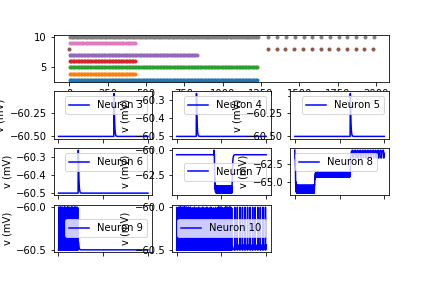

In [14]:
%matplotlib notebook

sim.setup(timestep=0.1,min_delay=0.1,max_delay=4.0)
population=get_pop()
sim.initialize(population, v=population.get('v_rest'))

sspoi_red_left_eye = sim.create(sim.SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 0.0})
sspoi_red_right_eye = sim.create(sim.SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 0.0})
sspoi_green_blue_eye = sim.create(sim.SpikeSourcePoisson,  {'start': 0.0, 'duration': 10000000000.0, 'rate': 0.0})

connE = sim.connect(sspoi_red_left_eye, population[slice(0, 3, 2)], weight=1.0, receptor_type='excitatory',delay=2.0)
connE = sim.connect(sspoi_red_right_eye, population[slice(1, 4, 2)], weight=1.0, receptor_type='excitatory',delay=2.0)
connE = sim.connect(sspoi_green_blue_eye, population[4], weight=1.0, receptor_type='excitatory',delay=2.0)

class SetRate(object):
    """
    A callback which changes the firing rate of a population of poisson
    processes at a fixed interval.
    """

    def __init__(self, source, interval=20.0):
        assert isinstance(source.celltype, sim.SpikeSourcePoisson)
        self.source = source
        self.interval = interval
        self.rate = 1000.00001
        
    def __call__(self, t):
        # t: time in ms
        try:
            self.source.set(rate=self.rate)
        except StopIteration:
            pass
        return t + self.interval

interval = 20.0

population.record('v')
population.record('spikes')

rate_red_left_eye = SetRate(sspoi_red_left_eye, interval)
rate_red_right_eye = SetRate(sspoi_red_right_eye, interval)
rate_green_blue_eye = SetRate(sspoi_green_blue_eye, interval)

sim.run(400.0, callbacks=[rate_red_left_eye,rate_red_right_eye,rate_green_blue_eye])

rate_red_left_eye.rate = 2000
rate_red_right_eye.rate = 0.001
rate_green_blue_eye.rate = 1000
sim.run(400.0, callbacks=[rate_red_left_eye,rate_red_right_eye,rate_green_blue_eye])

rate_red_left_eye.rate = 1000
rate_red_right_eye.rate = 1000
rate_green_blue_eye.rate = 0.001
sim.run(400.0, callbacks=[rate_red_left_eye,rate_red_right_eye,rate_green_blue_eye])

rate_red_left_eye.rate = 0.001
rate_red_right_eye.rate = 1000
rate_green_blue_eye.rate = 2000
sim.run(400.0, callbacks=[rate_red_left_eye,rate_red_right_eye,rate_green_blue_eye])

rate_red_left_eye.rate = 0.001
rate_red_right_eye.rate = 0.001
rate_green_blue_eye.rate = 100
sim.run(400.0, callbacks=[rate_red_left_eye,rate_red_right_eye,rate_green_blue_eye])

data_out = population.get_data()

vm = data_out.segments[0].filter(name="v")[0]

# plt.subplot(2, 2, 1)

plt.subplot(4, 1, 1)
for spiketrain in data_out.segments[0].spiketrains:
    y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
    plt.plot(spiketrain, y, '.')
    plt.setp(plt.gca().get_xticklabels(), visible=True)

for signal in data_out.segments[0].analogsignals:
    for i in range(signal.shape[1]):
        plt.subplot(4, 3, i+4)
        label = "Neuron %d" % signal.annotations['source_ids'][i]
        plt.plot(signal.times, signal[:, i], 'b', label=label)
        plt.ylabel("%s (%s)" % (signal.name, signal.units._dimensionality.string))
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.legend()



In [ ]:
a = [0,1,2,3,4,5,6,7]
a[slice(0, 3, 2)]
a[0:5:2]
a[0:2]

In [ ]:
# population.get_data().segments[0].spiketrains
population?

In [ ]:
run(a,c,b,c)